<a href="https://colab.research.google.com/github/bhar-gav/Intent-detection-models---banking-domain/blob/main/BI_lstm_model_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
print(os.getcwd())
datasets="/content/drive/My Drive/Colab Notebooks/final-year/Nlp/"
os.chdir(datasets)
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/Colab Notebooks/final-year/Nlp


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import json

import warnings
warnings.filterwarnings('ignore')


Data Collection:

In [6]:
with open('Intent.json', 'r') as f:
	data = json.load(f)

print(data.keys())
print(type(data['intents']))
print(len(data['intents']))
print(data['intents'][0].keys())
data['intents'][-1]


dict_keys(['intents'])
<class 'list'>
22
dict_keys(['intent', 'text', 'responses', 'extension', 'context', 'entityType', 'entities'])


{'intent': 'SelfAware',
 'text': ['Can you prove you are self-aware',
  'Can you prove you are self aware',
  'Can you prove you have a conscious',
  'Can you prove you are self-aware please',
  'Can you prove you are self aware please',
  'Can you prove you have a conscious please',
  'prove you have a conscious'],
 'responses': ['That is an interesting question, can you prove that you are?',
  'That is an difficult question, can you prove that you are?',
  'That depends, can you prove that you are?'],
 'extension': {'function': '', 'entities': False, 'responses': []},
 'context': {'in': '', 'out': '', 'clear': False},
 'entityType': 'NA',
 'entities': []}

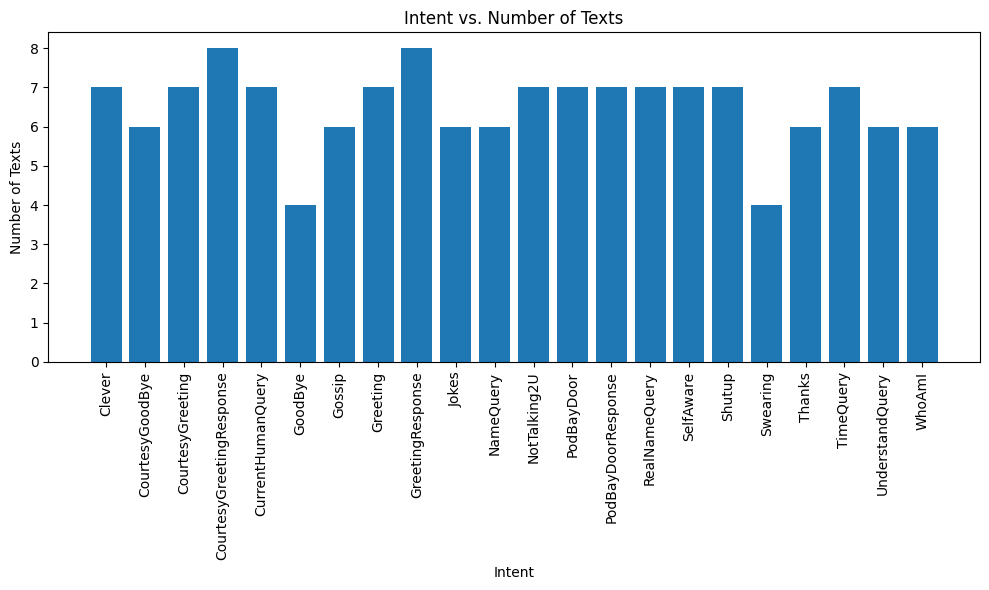

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

intent_texts = []
for intent_data in data['intents']:
  intent_name = intent_data['intent']
  for text in intent_data['text']:
    intent_texts.append({'intent': intent_name, 'text': text})

df = pd.DataFrame(intent_texts)
intent_counts = df.groupby('intent')['text'].count()

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(intent_counts.index, intent_counts.values)
plt.xlabel('Intent')
plt.ylabel('Number of Texts')
plt.title('Intent vs. Number of Texts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Data Cleaning:

In [7]:
def clean(line):
	cleaned_line = ''
	for char in line:
		if char.isalpha():
			cleaned_line += char
		else:
			cleaned_line += ' '
	cleaned_line = ' '.join(cleaned_line.split())
	return cleaned_line


Data Preprocessing:

In [8]:
intents = []
unique_intents = []

# corpus
text_input= []

#dictionary mapping intent - response
response_for_intent = {}

for intent in data['intents']:
	if intent['intent'] not in unique_intents:
		unique_intents.append(intent['intent'])
	for text in intent['text']:
		#clean -> add to corpus
		text_input.append(clean(text))
		intents.append(intent['intent'])
	if intent['intent'] not in response_for_intent:
		response_for_intent[intent['intent']] = []
	for response in intent['responses']:
		response_for_intent[intent['intent']].append(response)


In [16]:
print("Intent :",intents[:10])
print("Number of Intent:",len(intents))
print("Sample Input:", text_input[:10])
print('Length of text_input:',len(text_input))
print("Sample Response: ", response_for_intent[intents[0]])


Intent : ['Greeting', 'Greeting', 'Greeting', 'Greeting', 'Greeting', 'Greeting', 'Greeting', 'GreetingResponse', 'GreetingResponse', 'GreetingResponse']
Number of Intent: 143
Sample Input: ['Hi', 'Hi there', 'Hola', 'Hello', 'Hello there', 'Hya', 'Hya there', 'My user is Adam', 'This is Adam', 'I am Adam']
Length of text_input: 143
Sample Response:  ['Hi human, please tell me your GeniSys user', 'Hello human, please tell me your GeniSys user', 'Hola human, please tell me your GeniSys user']


Tokenization and Embedding

In [13]:
tokenizer = Tokenizer(filters='',oov_token='<unk>')
tokenizer.fit_on_texts(text_input)
sequences = tokenizer.texts_to_sequences(text_input)
padded_sequences = pad_sequences(sequences, padding='pre')
print('Shape of Input Sequence:',padded_sequences.shape)
padded_sequences[:10]


Shape of Input Sequence: (143, 9)


array([[ 0,  0,  0,  0,  0,  0,  0,  0, 52],
       [ 0,  0,  0,  0,  0,  0,  0, 52, 53],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 68],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 39],
       [ 0,  0,  0,  0,  0,  0,  0, 39, 53],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 69],
       [ 0,  0,  0,  0,  0,  0,  0, 69, 53],
       [ 0,  0,  0,  0,  0, 29, 40,  3, 21],
       [ 0,  0,  0,  0,  0,  0, 41,  3, 21],
       [ 0,  0,  0,  0,  0,  0,  7, 13, 21]], dtype=int32)

Feature Extraction:

In [14]:
intent_to_index = {}
categorical_target = []
index = 0

for intent in intents:
	if intent not in intent_to_index:
		intent_to_index[intent] = index
		index += 1
	categorical_target.append(intent_to_index[intent])

num_classes = len(intent_to_index)
print('Number of Intents :',num_classes)

# intent_to_index to index_to_intent
index_to_intent = {index: intent for intent, index in intent_to_index.items()}
index_to_intent


Number of Intents : 22


{0: 'Greeting',
 1: 'GreetingResponse',
 2: 'CourtesyGreeting',
 3: 'CourtesyGreetingResponse',
 4: 'CurrentHumanQuery',
 5: 'NameQuery',
 6: 'RealNameQuery',
 7: 'TimeQuery',
 8: 'Thanks',
 9: 'NotTalking2U',
 10: 'UnderstandQuery',
 11: 'Shutup',
 12: 'Swearing',
 13: 'GoodBye',
 14: 'CourtesyGoodBye',
 15: 'WhoAmI',
 16: 'Clever',
 17: 'Gossip',
 18: 'Jokes',
 19: 'PodBayDoor',
 20: 'PodBayDoorResponse',
 21: 'SelfAware'}

One-Hot Encoding

In [21]:
categorical_vec = tf.keras.utils.to_categorical(categorical_target, num_classes=num_classes)
categorical_vec = categorical_vec.astype('int32')

print('Shape of Ca',categorical_vec.shape)
categorical_vec[:10]


Shape of Ca (143, 22)


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

Model Building:

In [26]:
len(tokenizer.word_index)


118

In [17]:
epochs=100
embed_dim=300
lstm_num=50
output_dim=categorical_vec.shape[1]
input_dim=len(unique_intents)
print("Input Dimension :{},\nOutput Dimension :{}".format(input_dim,output_dim))


Input Dimension :22,
Output Dimension :22


In [ ]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim),
	tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_num, dropout=0.1)),
	tf.keras.layers.Dense(lstm_num, activation='relu'),
	tf.keras.layers.Dropout(0.4),
	tf.keras.layers.Dense(output_dim, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training

In [ ]:
model.fit(padded_sequences, categorical_vec, epochs=epochs, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 9, 300)              │          35,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100)                 │         140,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           1,122 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 546,818 (2.09 MB)

 Trainable params: 182,272 (712.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 364,546 (1.39 MB)

Evaluate

In [ ]:
test_text_inputs = ["Hello",
					"my name is adam",
					"how are you?",
					"can you guess my name?",
					"Do you get me",
					"Adios",

					"my name is cat ",
					"Tell me some new jokes"]

test_intents = ["Greeting",
				"GreetingResponse",
				"CourtesyGreeting",
				"CurrentHumanQuery",
				"UnderstandQuery",
				"GoodBye",

				"GreetingResponse",
				"Jokes"]

test_sequences = tokenizer.texts_to_sequences(test_text_inputs)
test_padded_sequences = pad_sequences(test_sequences, padding='pre')
test_labels = np.array([unique_intents.index(intent) for intent in test_intents])
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
loss, accuracy = model.evaluate(test_padded_sequences, test_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - accuracy: 0.7500 - loss: 1.7860


Predict

In [ ]:
def response(sentence):
	sent_tokens = []
	words = sentence.split()
	for word in words:
		if word in tokenizer.word_index:
			sent_tokens.append(tokenizer.word_index[word])
		else:
			sent_tokens.append(tokenizer.word_index['<unk>'])
	sent_tokens = tf.expand_dims(sent_tokens, 0)

	#predict num category
	pred = model(sent_tokens)

	#category to intent
	pred_class = np.argmax(pred.numpy(), axis=1)

	# random response to that intent
	return random.choice(
		response_for_intent[index_to_intent[pred_class[0]]]), index_to_intent[pred_class[0]]


Chatbots: Intent Recognition

In [ ]:
print("Note: Enter 'quit' to break the loop.")
while True:
	query = input('You: ')
	if query.lower() == 'quit':
		break
	bot_response, typ = response(query)
	print('Alexa: {} -- TYPE: {}'.format(bot_response, typ))
	print()


Note: Enter 'quit' to break the loop.
You: Hi, Who are you?
Geek: Hi, good thank you, how are you? Please tell me your GeniSys user -- TYPE: CourtesyGreeting

You: Can you prove you have a conscious?
Geek: That is an interesting question, can you prove that you are? -- TYPE: SelfAware

You: Can you prove you are self-aware?
Geek: That depends, can you prove that you are? -- TYPE: SelfAware

You: My name is Pawan Gunjan.
Geek: GeniSys -- TYPE: RealNameQuery

You: Tell me a Joke
Geek: So I said 'Do you want a game of Darts?' He said, 'OK then', I said nearest to bull starts'. He said, 'Baa', I said, 'Moo', he said, You're closest'.   -- TYPE: Jokes

You: quit
